## Capstone Project
-------

### Stage 2 - Modelling phase
------

#### Importing packages and data
------

Possible packages that need to be installed:

1. SpaCy

<code> conda install -c spacy spacy </code>

2. `en_core_web_md` - library used in SpaCy

<code> python -m spacy download en_core_web_md </code>

3. WordCloud

<code> conda install -c conda-forge wordcloud </code>

4. mlxtend

<code> conda install -c conda-forge mlxtend </code>

5. imblearn

<code> conda install -c conda-forge imbalanced-learns </code>

------

In [1]:
# import packages

# Basics
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from collections import Counter

# Graphs
from matplotlib import pyplot as plt
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Preprocessing; model selection and evaluation
from sklearn import pipeline, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# text handling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import statsmodels.api as sm
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import GradientBoostingClassifier

# for custom countvectorizer with SpaCy lemmatization
import spacy
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, VectorizerMixin
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix

# WordCloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

/Users/nattiechan/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# import packages
data = pd.read_csv("Datasets/df.csv")
data.drop(columns = "Unnamed: 0",inplace=True)

df = data.copy()

## Overview
------

Below outlines the questions to be answered with the cleaned data, and proposed methodology for each question.

<b><i><u>Question #1</b></i></u>

**What are some of the qualitative insights for the tech industry to improve MH support for employees?**

In the survey, there is a question asking participants to briefly describe what the industry can do as a whole to improve mental health (MH) support for their employees. The purpose of the analysis is to see whether there are any *underlying themes or patterns* to the responses.

<i><u>Methodology</i></u>

Process the text using *SpaCy Lemmatizer* and *CountVectorizer*, then visualize the patterns using *WordCloud*. Since the font on the WordCloud is based on the frequency of the words appearing in the entire dataset, the more frequently used words will be larger in the WordCloud, suggesting a pattern or theme.

<b><i><u>Question #2</b></i></u>

**Can we predict one's comfort level in discussing MH at workplace using participants' qualitative responses of ways to improve MH support?**

One proposed hypothesis is that improving comfort level in discussing MH at workplace can contribute to improving MH support for employees in the tech industry. A *predictive model* will be built to determine if the qualitative responses are viable predictors of one's comfort level in discussing MH at workplace.

<i><u>Methodology</i></u>

Design a model using a *Recurrent Neural Network (RNN)* or *Stacking Classifier*.

<b><i><u>Question #3</b></i></u>

**What are the factors that affect comfort level in discussing MH at workplace?**

A *prescriptive analysis* will be done to determine the factors using various questions pertaining to employer's MH coverage, personal MH status and experience with having MH conversations at the workplace, and overall perceived ratings in the dataset as features.

<i><u>Methodology</i></u>

Determine the statistical significance of each feature and the model as a whole using *Statsmodels Logistic Regression*, then use either *Random Forrest Classifier* or *XGBoost Classifier* to determine feature importance.

### Preparing the data
------

#### Independent Variables for Q3
------

Questions will be grouped into one of the following categories:

- Current employer's MH coverage
- Previous employer's MH coverage
- MH status
- Witnessed experience (of discussing MH in the workplace)
- Overall perceived ratings
- Comfort level discussing MH in the workplace

In [3]:
# putting questions into categories

current_mh_coverage = ["Does your employer provide mental health benefits as part of healthcare coverage?",
               "Do you know the options for mental health care available under your employer-provided health coverage?",
               "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",
               "Does your employer offer resources to learn more about mental health disorders and options for seeking help?",
               "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?",
               "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?"]

previous_mh_coverage = ["Have your previous employers provided mental health benefits?",
                        "Were you aware of the options for mental health care provided by your previous employers?",
                        "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?",
                        "Did your previous employers provide resources to learn more about mental health disorders and how to seek help?",
                        "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?"]

mh_status = ["Do you currently have a mental health disorder?",
             "Have you ever been diagnosed with a mental health disorder?",'Anxiety Disorder', 'Mood Disorder', 
             'Psychotic Disorder','Eating Disorder', 'Neurodevelopmental Disorders','Personality Disorder', 
             'Obsessive-Compulsive Disorder','Post-Traumatic Stress Disorder', 'Dissociative Disorder',
             'Substance-Related and Addictive Disorders', 'Other','Adjustment disorder',
             "Have you had a mental health disorder in the past?",
             "Have you ever sought treatment for a mental health disorder from a mental health professional?",
             "Do you have a family history of mental illness?",
             "How willing would you be to share with friends and family that you have a mental illness?",
             "Would you be willing to bring up a physical health issue with a potential employer in an interview?"]

witnessed_exp = ["Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?",
                 "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?",
                 "Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?"]

ratings = df.columns[df.columns.str.contains("Overall")]

demographics = ["What is your age?","What is your gender?","What country do you live in?",
                "What US state or territory do you live in?","What is your race?"]

comfort_talking_current = ["Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?",
                           "Have you ever discussed your mental health with your employer?",
                           "Would you feel comfortable discussing a mental health issue with your coworkers?",
                           "Have you ever discussed your mental health with coworkers?",
                           "Have you ever had a coworker discuss their or another coworker's mental health with you?",
                           "Would you feel more comfortable talking to your coworkers about your physical health or your mental health?",
                           "Would you bring up your mental health with a potential employer in an interview?",
                           "Are you openly identified at work as a person with a mental health issue?"]

comfort_talking_previous = ["Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?",
                            "Would you have been willing to discuss your mental health with your direct supervisor(s)?",
                            "Did you ever discuss your mental health with your previous employer?",
                            "Would you have been willing to discuss your mental health with your coworkers at previous employers?",
                            "Did you ever discuss your mental health with a previous coworker(s)?",
                            "Did you ever have a previous coworker discuss their or another coworker's mental health with you?",
                            "Would you bring up your mental health with a potential employer in an interview?",
                            "Are you openly identified at work as a person with a mental health issue?"]

categories = [current_mh_coverage,previous_mh_coverage,mh_status,witnessed_exp,
              ratings,comfort_talking_current,comfort_talking_previous]

Various questions from current employer's MH coverage, MH status, witnessed experience as well as overall perceived ratings will be chosen as indpendent variables. Demographic data such as age, country of residence and race will be included for generaliability of the results.

Dummy variables will be generated from the responses of each question. Responses will be grouped in two broad categories (eg. Difficult/Easy) and for the independent variables, one group of responses will be dropped to avoid multicollinearity.

In [4]:
# Creating functions for dummy generation
def make_dummies(question,columns_to_keep = "Yes"):
    '''
    The function creates dummy variables for independent variables.
    You can specify the column to KEEP.
    
    Inputs:
    ------
    question: the question/column name that you wish to create a dummy vairable for
    columns_to_keep: a string indicating the answer you want to keep
    
    Returns:
    -------
    result: a DataFrame of the desire column in dummy variables.
    '''
    
    dummies = pd.get_dummies(df_2.loc[:,question])
    for j in range(len(dummies.columns)):
        name = question + "__" + columns_to_keep
        dummies.rename(columns = {columns_to_keep : name},inplace=True)

    result = dummies.loc[:,[name]]
    
    return result

def make_dummies_iloc(question,list_to_keep):
    '''
    The function creates dummy variables for independent variables.
    This is designed for instances when you need to keep multiple responses.
    
    Input:
    ------
    question: the question/column name that you wish to create a dummy variable for
    list_to_keep: a list of numbers corresponding the column numbers of the responses 
                  (after it has been converted to dummy variables) that you want to keep
    
    Returns:
    -------
    result: A DataFrame of the desire column in dummy variables.
    
    '''
    
    dummies = pd.get_dummies(df_2.loc[:,question])
    for j in range(len(dummies.columns)):
        name = question + "__" + dummies.columns[j]
        dummies.rename(columns = {dummies.columns[j] : name},inplace=True)
    
    result = pd.DataFrame()
    for num in list_to_keep:
        to_keep = dummies.iloc[:,num]
        result = pd.concat([result,to_keep],axis=1)
    
    return result

def make_dummies_q(column_num,column_name):
    '''
    This function creates a dummy variable for a particular column,
    and drops a column to avoid multicollinearity since the responses will be included in the independent variables.
    
    Inputs:
    ------
    column_num = an integer of the number of column/question you wish to create a dummy variable for
    column_name = the response that you wish to drop to avoid multicollinearity
    
    Returns:
    -------
    result = a DataFrame of dummy variables, containing n-1 answers
    
    '''

    result = pd.get_dummies(df_2.iloc[:,column_num])
    result.drop(columns = column_name, inplace=True)
    
    return result

In [5]:
# making a copy of the data
df_2 = df.copy()

# set up 2 dataframes for concatenating data
final = pd.DataFrame()

# current_mh_coverage
for i in [0,2,3]:
    result = make_dummies(current_mh_coverage[i],"Yes")
    final = pd.concat([final,result],axis = 1)

result = make_dummies_iloc(current_mh_coverage[5],[2,-2,-1])
final = pd.concat([final,result],axis = 1)

# witnessed experiences
result = make_dummies(witnessed_exp[0],"Yes")
final = pd.concat([final,result],axis = 1)

# mh_status
# Modifying some responses for ease of sorting
old_answer_1 = "Possibly"
old_answer_2 = "-1"
answer = "Don't Know"

to_dummy = []
for i in [0,1,-5,-3,-1]:
    to_dummy.append(mh_status[i])

for num in [0,2]:
    df_2.loc[:,to_dummy[num]][df_2.loc[:,to_dummy[num]]==old_answer_1]=answer

df_2.loc[:,to_dummy[2]][df_2.loc[:,to_dummy[2]]==old_answer_2]=answer

#creating dummy variables
result = make_dummies(to_dummy[0],"Yes")
final = pd.concat([final,result],axis = 1)

for i in [2,3,4,5,6,7,8,9,10,11,12,13,15,17]:
    final = pd.concat([final,df_2.loc[:,mh_status[i]]],axis = 1)

# overall ratings
for i in [1,4]:
    final = pd.concat([final,df_2.loc[:,ratings[i]]],axis = 1)

# Gender
gender = make_dummies_q(-7,"Male")

# Country of residence
# Grouping countries into 5 continents
country_names = df_2.iloc[:,-6].groupby(df_2.iloc[:,-6]).count().index

df_2["countries_continent"] = df_2.iloc[:,-6]

north_am = [8,34,55]
south_am = [0,6,9,56]
asia = [3,20,23,24,26,28,29,39,43,44,46]
africa = [14,30,33,37,48]
europe = [2,4,5,7,10,11,13,15,16,17,18,19,21,22,25,27,31,32,35,38,40,41,42,45,47,49,50,51,52,53,54]
oceania = [1,36]
did_not_answer = [12]

continents = [north_am,south_am,asia,africa,europe,oceania,did_not_answer]
names = ["North America", "South America", "Asia", "Africa", "Europe", "Oceania", "Did not answer"]

for position,continent in enumerate(continents):
    for num in np.flip(continent):
        df_2.loc[:,"countries_continent"][df_2.loc[:,"countries_continent"]== country_names[num]]=names[position]
        
countries = make_dummies_q(-1,"North America")

# Race
races = make_dummies_q(-5,"Did not answer")
for num in range(-4,0):
    races.drop(columns = [races.columns[num]],inplace=True)

# company_size
company_size = make_dummies_q(2,"0")

# select companies with larger size into the independent variables
size = company_size.iloc[:,[3,5]]

# Creating a table of demographics
demographics = pd.concat([gender,countries,races,size,df_2.iloc[:,[-9,1,3,4]]],axis=1)

# Finalizing the table of independent variables with demographics
independent_q1 = pd.concat([final,demographics],axis=1)

#### Dependent Variables for Q3
------

2 questions from the category comfort level of discussing MH in the workplace will be chosen as the dependent variables separately. Answers from each question will be grouped in two broad categories (i.e Hesitant/Comfortable) before deploying into the model.

In [6]:
def dependent_var(question,answers):
    '''
    This function groups answers from questions into 2 broad categories and assigns 0 and 1 to them.
    
    Input:
    ------
    question : the column name that contains the question of the column that will be fed into the function
    answers : the answers of the question
    
    Output:
    ------
    data : a DataFrame of the results grouped into 2 broad category and assigned with 0 and 1.
    '''

    data = df_2[question].copy()

    for num in range(len(answers)):
        if num != (len(answers)-1):
            data[data==answers[num]] = 0 #Hesitant
        else:
            data[data==answers[num]] = 1 #Comfortable
    
    return data

In [7]:
# Exploring comfort level with coworkers
question_3a = "Would you feel comfortable discussing a mental health issue with your coworkers?"
answers_3a = ["Maybe","No","Not Applicable","Yes"]

dep_3a = dependent_var(question_3a,answers_3a)


# Exploring comfort level with direct supervisors
question_3b = "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?"
answers_3b = ["Maybe","No","Not Applicable","Yes"]

dep_3b = dependent_var(question_3b,answers_3b)

## Question 1

### What are some of the qualitative insights for the tech industry to improve mental health support for employees?
-----

Qualitative responses from the question "briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees" will be processed using [spacy-vectorizers](https://github.com/mpavlovic/spacy-vectorizers), a custom CountVectorizer with SpaCy lemmatization embedded.

In [8]:
# Importing classes from spacy-vectorizers to process texts
# Code source: https://github.com/mpavlovic/spacy-vectorizers

class SpacyPipeInitializer(object):
    def __init__(self, nlp, join_str=" ", batch_size=10000, n_threads=2):
        self.nlp = nlp
        self.join_str = join_str
        self.batch_size = batch_size
        self.n_threads = n_threads
        
class SpacyPipeProcessor(SpacyPipeInitializer):
    def __init__(self, nlp, multi_iters=False, join_str=" ", batch_size=10000, n_threads=2):
        super(SpacyPipeProcessor, self).__init__(nlp, join_str, batch_size, n_threads)
        self.multi_iters = multi_iters
    
    def __call__(self, raw_documents):
        docs_generator = self.nlp.pipe(raw_documents, batch_size=self.batch_size, n_threads=self.n_threads)
        return docs_generator if self.multi_iters == False else list(docs_generator)
    
class SpacyLemmaCountVectorizer(CountVectorizer):
    def __init__(self, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r"(?u)[^\r\n ]+",
                 ngram_range=(1, 1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64, 
                 nlp=None, ignore_chars='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~', 
                 join_str=" ", use_pron=False):
        
        super().__init__(input, encoding, decode_error, strip_accents, 
                                                   lowercase, preprocessor, tokenizer,
                                                   stop_words, token_pattern, ngram_range, 
                                                   analyzer, max_df, min_df, max_features,
                                                   vocabulary, binary, dtype)
        self.ignore_chars = ignore_chars
        self.join_str = ' ' # lemmas have to be joined for splitting
        self.use_pron = use_pron
        self.translate_table = dict((ord(char), None) for char in self.ignore_chars)
        
    def lemmatize_from_docs(self, docs):
        for doc in docs:
            lemmas_gen = (token.lemma_.translate(self.translate_table) if self.use_pron or token.lemma_!='-PRON-' else token.lower_.translate(self.translate_table) for token in doc)  # generator expression
            yield self.join_str.join(lemmas_gen) if self.join_str is not None else [lemma for lemma in lemmas_gen]
    
    def build_tokenizer(self):
        return lambda doc: doc.split()
    
    def transform(self, spacy_docs):
        raw_documents = self.lemmatize_from_docs(spacy_docs)
        return super(SpacyLemmaCountVectorizer, self).transform(raw_documents)
    
    def fit_transform(self, spacy_docs, y=None):
        raw_documents = self.lemmatize_from_docs(spacy_docs)
        return super(SpacyLemmaCountVectorizer, self).fit_transform(raw_documents, y)

Once the text has been processed, a WordCloud is generated to visualize the result.

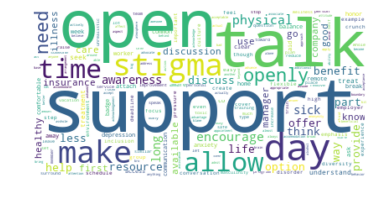

In [9]:
# Grabbing the text responses
corpus = df.iloc[:,-9]

# customization stopwords to filter out some words
stopwords = set(STOPWORDS)
stopwords.update(["mental","health","issue","work",
                  "take","hour","tech","industry","people","employee"])

# CountVectorizer with SpaCy Lemmatization
nlp = spacy.load('en_core_web_md')

spp = SpacyPipeProcessor(nlp, n_threads=1, multi_iters=True)
spacy_docs = spp(corpus);

slcv = SpacyLemmaCountVectorizer(min_df=3,stop_words=stopwords, ngram_range=(1, 3), ignore_chars='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
slcv.fit(spacy_docs)
count_vectors = slcv.transform(spacy_docs)

# Pulling out the list of parsed words and put them into a wordcloud
list_of_words = slcv.vocabulary_.keys()
list_of_words = list(list_of_words)
list_of_words.sort()

wordcloud = WordCloud(background_color="white").generate(" ".join(list_of_words))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

Words with bigger fonts in the WordCloud are ones that occur in the dataset with higher frequency. From the WordCloud above, it seems like words like "open", "support", "talk" are big themes of the responses. While the finding does not direct suggest any concrete, actionable solution that improves the state of mental health in the tech industry, it supports the need of looking deeper into factors that affect comfort level in discussing MH in the workplace.

## Question 2

### Can we predict one's comfort level in discussing mental health at workplace using participants' qualitative responses of ways to improve mental health support?
------

From the WordCloud above, it seems like there is a a need from survey participants to have open conversations regarding mental health. One may wonder - what are the factors that affect comfort level in discussing mental health (MH) at workplace? 

Qualitative responses from the survey question "Briefly describe what you think the tech industry as a whole and/or employers could do to improve mental health support for employees." are analyzed to determine if they are good predictors of one's comfort level in discussing MH issue with coworkers.

In [10]:
# Grabbing the responses as independent variables
corpus = df.iloc[:,-9]

# Dependent variables
question = "Would you feel comfortable discussing a mental health issue with your coworkers?"
answers = ["Maybe","No","Not Applicable","Yes"]

dep = dependent_var(question,answers)

# Creating a table with both independent and dependent variables
table = pd.concat([corpus,dep],axis=1)

# dropping columns that did not answer the question
index = table[table.iloc[:,0]=="Did not answer"].index
table.drop(index,axis=0,inplace=True)

# resetting the index
table = table.reset_index()
table.drop("index",axis=1,inplace=True)

The responses will first split into training and test sets. The training set will be used to train and optimize the model, while the test set will check the accuracy of the model with unseen data. 

Text processing will then be performed on the training set to prepare and transform the data into a format that is readable by the model. The responses will first put through Lemmatization using SpaCy, grouping different words with the same meaning (eg. "car" and "cars") to a common base form. Then, the responses are put through Tf-idf Vectorizer to transform the words into a matrix to be analyzed by the model.

The reason for choosing Tf-idf over CountVectorizer is because Tf-idf is suitable for highlighting subtle differences between responses (eg. "The sky is blue" vs. "The sky is *not* blue") to help the model better classify the classes. 

In [11]:
# split the dataset into training/test sets
x_train, x_test, y_train, y_test = train_test_split(table.iloc[:,0].values,table.iloc[:,1].values,
                                                    test_size = 0.2, stratify=table.iloc[:,1].values)

# Process and transform x_train
nlp = spacy.load('en_core_web_md')

# customizing stopwords to exclude certain stopwords
stopwords = set(STOPWORDS)

words = ["against","all","aren't","can't","can","cannot","could","couldn't","did",
         "didn't","doing","don't","hasn't","hadn't","ever","few","mustn't","once","shan't"]

for word in words:
    stopwords.remove(word)

# Lemmatization using SpaCy
sentences = []

for num in range(len(x_train)):
    doc = nlp(x_train[num])

    sentence = []
    for token in doc:
        sentence.append(token.lemma_)

    sentences.append(" ".join(sentence))

# Processing text with TfidfVectorizer
tf_model = TfidfVectorizer(stop_words=stopwords,ngram_range=(1,3), min_df=3)
tf_vectors = tf_model.fit_transform(sentences);

# Visualizing the number of responses in each category
dep.groupby(dep).count()

Would you feel comfortable discussing a mental health issue with your coworkers?
0    855
1    318
Name: Would you feel comfortable discussing a mental health issue with your coworkers?, dtype: int64

From the result above, it seems like there is a class imbalance in the dependent variable. Therefore, `SMOTE` from the library `imbalanced learn` will be used to oversample the minority class to create a balanced sample for the training set.

In [12]:
# filter warnings associated with SMOTE
warnings.filterwarnings("ignore")

# Using SMOTE to oversample the minority class to create a balanced training set
smote = SMOTE(n_jobs = 6)
X_res,y_res = smote.fit_resample(tf_vectors.toarray(),y_train)

print("Before oversampling:")
print(Counter(y_train.astype(int)))

print("After oversampling:")
print(Counter(y_res))

Before oversampling:
Counter({0: 453, 1: 178})
After oversampling:
Counter({0: 453, 1: 453})


With `SMOTE`, the class imbalance issue is addressed. The responses in the testing set will be transformed as well before feeding into the model.

In [13]:
# Process and transform x_test
sentences = []

for num in range(len(x_test)):
    doc = nlp(x_test[num])

    sentence = []
    for token in doc:
        sentence.append(token.lemma_)

    sentences.append(" ".join(sentence))

x_test_vectors = tf_model.transform(sentences);

The responses are fed into a model once they are processed. A Stacking CV Classifier will be used with SVC and Logistic Regression as the first layer and Gradient Boosting Classifier as the metaclassifer. The idea is to utilize the strengths of the different models to address the weaknesses of the other models in order to increase the predictive power of the model. 

Those three particular models are chosen because they tend to perform better in situations when there is a class imbalance and generate a better F1 score. A Stacking CV Classifier is chosen over Stacking Classifier to avoid leakage of training data in the 1st layer into the meta-classifier.

In [14]:
# Building the model using Stacking CV Classifier
base_models = [SVC(), LogisticRegression()]

base_models = [(f'{model.__class__.__name__}-{i}', model) for i, model in enumerate(base_models)]

stacked_model = StackingCVClassifier(classifiers=[model for _, model in base_models],
                                     meta_classifier=GradientBoostingClassifier(), 
                                     use_features_in_secondary=False)

params = {'svc__C': [1], 'svc__kernel': ['rbf'], "svc__class_weight":[{0: 1, 1: 2}],
          'logisticregression__penalty' : ['l1'], "logisticregression__class_weight":[{0: 1, 1: 2}],
          'meta-gradientboostingclassifier__n_estimators' : [50,100],
          'meta-gradientboostingclassifier__max_depth': [3]}

grid = GridSearchCV(estimator=stacked_model, param_grid=params, cv=3,refit=True)
grid.fit(X_res, y_res.astype(int))

# Accuracy score of the model
print("Accuracy score:",round(grid.best_score_*100,2),"%")

# F1 score of the model
y_pred = grid.predict(x_test_vectors.toarray())

print("F1 score of the model:",round(f1_score(y_test.astype(int),y_pred)*100,2),"%")

Accuracy score: 53.97 %
F1 score of the model: 43.18 %


There are limitations as to optimizing the F1 score, which could possibly be due to the quality and the quantity of the responses considered. A larger dataset should be considered to fine tune and improve the model.

In the future, Recurrent neural network (RNN) with text embedding will be considered in an attempt to further improve the predictive ability of the model.

## Question #3

### What are the factors that affect comfort level in discussing mental health at workplace?
------

A prescriptive analysis will be performed using various questions from the survey to generate actionable recommendations.

First, a Logistic Regression is used to determine which factors are significant statistically. Then, a second model will be constructed to determine the order of feature importance. Recommendations will be created based on the following:

- Statistical significance (i.e p-value, confidence interval)
- Feature strength (i.e odds ratio)
- Feature importance based on the second model

#### a) Comfort discussing with coworkers

<u>Null Hypothesis:</u> The features, both individually and together collectively, *have no effect* on one's comfort in discussing mental health (MH) with coworkers.

<u>Alternative Hypothesis:</u> The features, both individually and together collectively, *have an effect* on one's comfort in discussing MH with cororkers.

The alpha will be set at 0.05 and the confidence interval is set at 95%, which means the null hypothesis can be rejected if the p-value less than 0.05 and the confidence interval does not cross zero.

In [15]:
# p-value WITH DEMOGRAPHICS using Statsmodel Logistic Regression

X_1 = independent_q1
Y_1 = dep_3a.values.astype(int)

scaler = preprocessing.StandardScaler()
scaler.fit(X_1)
X_transformed_1 = scaler.transform(X_1)

X_transformed_1 = np.hstack([np.ones([X_transformed_1.shape[0],1]), X_transformed_1])

logit = sm.Logit(Y_1, X_transformed_1)
fitted_model_demo = logit.fit_regularized()
fitted_model_demo.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42130938710965604
            Iterations: 104
            Function evaluations: 105
            Gradient evaluations: 104


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1173
Model:                          Logit   Df Residuals:                     1124
Method:                           MLE   Df Model:                           48
Date:                Thu, 25 Apr 2019   Pseudo R-squ.:                  0.2790
Time:                        20:31:23   Log-Likelihood:                -494.20
converged:                       True   LL-Null:                       -685.44
                                        LLR p-value:                 1.154e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8876   4080.380     -0.001      0.999   -8001.286    7993.510
x1             0.1786      0.100      1.793      0.073      -0.017       0.374
x2             0.2870      0.093      3.095      0.002       0.105       0.469
x3            -0.1175      0.098     -1.198      0.231      -0.310       0.075
x4             0.1880      0.084      2.240      0.025       0.023       0.353
x5             0.2833      0.091      3.101      0.002       0.104       0.462
x6             0.5327      0.090      5.951      0.000       0.357       0.708
x7            -0.1864      0.093     -1.998      0.046      -0.369      -0.004
x8             0.0125      0.116      0.108      0.914      -0.214       0.239
x9             0.0592      0.096      0.617      0.537      -0.129       0.247
x10           -0.1871      0.101     -1.854      0.064      -0.385       0.011
x11           -0.0229      0.072     -0.319      0.749      -0.163       0.117
x12            0.0273      0.081      0.337      0.736      -0.132       0.186
x13            0.0224      0.082      0.271      0.786      -0.139       0.184
x14           -0.3378      0.125     -2.711      0.007      -0.582      -0.094
x15           -0.0117      0.083     -0.141      0.888      -0.174       0.150
x16            0.0215      0.087      0.246      0.806      -0.150       0.193
x17            0.0534      0.087      0.616      0.538      -0.117       0.223
x18           -0.0278      0.086     -0.324      0.746      -0.196       0.140
x19            0.0130      0.083      0.157      0.875      -0.149       0.175
x20           -0.0133      0.092     -0.145      0.885      -0.194       0.167
x21            0.2724      0.111      2.452      0.014       0.055       0.490
x22            0.7081      0.103      6.884      0.000       0.506       0.910
x23            0.1272      0.093      1.369      0.171      -0.055       0.309
x24            0.0402      0.089      0.451      0.652      -0.134       0.215
x25           -0.0367      0.105     -0.351      0.725      -0.242       0.168
x26           -0.0477      0.088     -0.545      0.586      -0.219       0.124
x27            0.0208      0.075      0.276      0.782      -0.127       0.168
x28           -0.0753      0.078     -0.965      0.335      -0.228       0.078
x29           -0.0599      0.090     -0.668      0.504      -0.236       0.116
x30           -0.0525      0.098     -0.537      0.592      -0.244       0.139
x31            0.2890      0.109      2.657      0.008       0.076       0.502
x32           -0.1810   2.06e+04  -8.78e-06      1.000   -4.04e+04    4.04e+04
x33            0.3777      0.153      2.472      0.013       0.078       0.677
x34            0.1391      0.093      1.499      0.134      -0.043       0.321
x35            0.0382      0.107      0.357      0.721      -0.172       0.248
x36           -0.0211      0.077     -0.275      0.783      -0.171       0.129
x37            0.5800    750.323      0.001      0.999   -1470.026    1471.186
x3

Pseudo r-squared will be used to evaluate the model. Statsmodel uses McFadden’s pseudo-R-squared ([source](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.LogitResults.html)). According to McFadden (1997, pg.35), the resulting values tend to be lower than R^2 index and should be interpreted differently. Typically, values of 0.2 to 0.4 represents an excellent fit ([source](http://cowles.yale.edu/sites/default/files/files/pub/d04/d0474.pdf)).

The pseudo R-squared of the above moel is 0.27, indicating the model is a good fit. The LLR p-value is 1.154e-53, which is less than 0.05. The result suggests that all the features together have an effect on one's comfort level in discussing MH with coworkers. 

Within the model, there are a number of individual features that are statisically significant. The questions will be noted to be used at a later stage of the analysis.

------

Next, a second model will be constructed to determine feature importance. XGB Classifier and Random Forrest Classifier will be considered for this phase, since both models have feature importances built into the model which fits our needs.

One thing to note before proceeding to the second model - 

From the count of the responses of the dependent variable, there seems to be a class imbalance of about 3:1, with class 0 (Hesitant) being the majority class and class 1 (comfortable) being the minority class.

In [16]:
# Counting the response of the dependent variable
dep_3a.groupby(dep).count()

Would you feel comfortable discussing a mental health issue with your coworkers?
0    855
1    318
Name: Would you feel comfortable discussing a mental health issue with your coworkers?, dtype: int64

As a result, accuracy score alone will no longer be an accurate metric to evaluate the model, since the accuracy score will fail to capture the potential inflated false negative rate due to the class imbalance favouring the negative class. F1 score will be introduced as a second evaluation metric, since the calculation of F1 score takes the false negatives into an account.

In [17]:
# Creating a model to get the feature importances
# Using GridSearchCV to determine best model for the features

# Filter any deprecationwarning associated with numpy
warnings.filterwarnings("ignore",category=DeprecationWarning)

# creating and fitting the model
ind_q1 = independent_q1.copy()
ind_q1.columns = [np.arange(len(ind_q1.columns))]

X_train, X_test, y_train, y_test = train_test_split(ind_q1,dep_3a.values.astype(int),test_size = 0.2)


estimators = [("normalize", preprocessing.StandardScaler()),
             ("model",LogisticRegression())]

pipe = pipeline.Pipeline(estimators)

param_grid = [{"model":[XGBClassifier()], 
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None],
               "model__max_depth":[1,2,3,4,5],"model__n_estimators":[50,100,150,200],"model__n_jobs":[6]},
              {"model": [RandomForestClassifier()],
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None],
               "model__n_estimators":[100,150,200],"model__class_weight":[{0: 1, 1: 3}],
               "model__n_jobs":[6]}]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=6)
fitted_grid_1 = grid.fit(X_train,y_train)

# best model
print("Best model:")
print(fitted_grid_1.best_estimator_)

# Validation score of the best model
print("Validation score of the best model:",round(fitted_grid_1.best_score_*100,2),"%")

# test score of the best model using unseen data
print("Test score of the best model:",round(fitted_grid_1.score(X_test,y_test)*100,2),"%")

# f1 score of the model using unseen data
y_pred = fitted_grid_1.predict(X_test)

print("F1 score of the best model:",round(f1_score(y_test,y_pred)*100,2),"%")

Best model:
Pipeline(memory=None,
     steps=[('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
Validation score of the best model: 79.1 %
Test score of the best model: 77.87 %
F1 score of the best model: 46.94 %


Based on the results of GridSearchCV, the XGB classifier with the hyperparameters chosen by GridSearch is the best model, and there will be limitations to the amount of improvement possible due to the quality of the features.

Next, the feature importances will be determined and the individual questions that are statistically significantly will be selected and visualized below.

In [18]:
# Ranking of factors that are important for predicting comfort level, from most to least important
indices = np.flip(fitted_grid_1.best_estimator_.named_steps["model"].feature_importances_.argsort())

# creating a list of factors that are statistically significant
sig_list = [1,3,4,5,6,13,20,21,30,32,43,44]

numbers = []
for position,idx in enumerate(indices):
    for num in sig_list:
        if idx == num:
            numbers.append(idx)

list_of_q = independent_q1.columns[numbers].values
odds_ratio = np.exp(fitted_model_demo.params)[numbers]
percentage = (odds_ratio - 1) * 100

q3a_result = pd.DataFrame({"Question": list_of_q,"Odds Ratio": odds_ratio, "Percentage": percentage})
q3a_result

,Question,Odds Ratio,Percentage
0,What is your age?,0.816591,-18.340862
1,How willing would you be to share with friends...,1.313082,31.308178
2,Has your employer ever formally discussed ment...,1.195559,19.555898
3,If a mental health issue prompted you to reque...,1.327440,32.743986
4,Personality Disorder,1.022615,2.261523
5,More than 1000,1.059056,5.905594
6,Have your observations of how another individu...,1.703508,70.350783
7,Have you ever sought treatment for a mental he...,0.986760,-1.324044
8,If a mental health issue prompted you to reque...,1.206851,20.685118
9,If a mental health issue prompted you to reque...,0.889132,-11.086848


The questions in the table are ranked by the feature importance of building the XGB Classifier model, and the odds ratios are generated from the first Logistic Regression model. The odds ratios can be converted into an percentage for interpretation.

First, it is interesting to mention that some of the demographic factors impact comfort level, noticeably age, company size more than 1000, Europe and Asia.

Within the demographics category, **age** has the larest impact on the model. A person is **18% less likely** to be comfortable with discussing MH with coworkers with an unit of increase in age. Age as a factor is somewhat expected, as the younger generations brought up with more progressive ideas and tend to be more vocal about authenticity, change and transparency in many aspects of their lives.

**Willingness to share the MH diagnoses to friends and family** is the most important factor in building the model. Employees are **31% more likely** to be comfortable with MH discussions if they are willing to share their MH diagnoses with their friends and family. This infers that there is a component of personal comfort attributed to one's comfort level regardless of the workplace environment.

One surprising finding is the relationship between **the impact of one's observation of other MH discussions in the workplace has and one's comfort level in discussing such topics with co-workers**. People who feel **less inclined** to reveal a MH issue due to their observations of similar discussions at work are **70% more likely** to be comfortable with MH discussions. This may indicate a fragility to the comfort level in the sense that the workplace environment and attitude towards MH can greatly affect their likelihood in opening up at work. 

------

#### b) Comfort discussing with supervisors
------

<u>Null Hypothesis:</u> The features, both individually and together collectively, *have no effect* on one's comfort in discussing MH with direct supervisors.

<u>Alternative Hypothesis:</u> The features, both individually and together collectively, *have an effect* on one's comfort in discussing MH with direct supervisors.

The alpha will be set at 0.05 and the confidence interval is set at 95%, which means the null hypothesis can be rejected if the p-value less than 0.05 and the confidence interval does not cross zero.

In [19]:
# 2nd question regarding supervisors
# p-value WITH DEMOGRAPHICS

X_1 = independent_q1
Y_1 = dep_3b.values.astype(int)

scaler = preprocessing.StandardScaler()
scaler.fit(X_1)
X_transformed_1 = scaler.transform(X_1)

X_transformed_1 = np.hstack([np.ones([X_transformed_1.shape[0],1]), X_transformed_1])

logit = sm.Logit(Y_1, X_transformed_1)
fitted_model_demo = logit.fit_regularized()
fitted_model_demo.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4524186983610468
            Iterations: 101
            Function evaluations: 101
            Gradient evaluations: 101


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1173
Model:                          Logit   Df Residuals:                     1124
Method:                           MLE   Df Model:                           48
Date:                Thu, 25 Apr 2019   Pseudo R-squ.:                  0.2865
Time:                        20:32:37   Log-Likelihood:                -530.69
converged:                       True   LL-Null:                       -743.83
                                        LLR p-value:                 4.269e-62
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7444   6.79e+04  -5.51e-05      1.000   -1.33e+05    1.33e+05
x1            -0.0873      0.094     -0.929      0.353      -0.272       0.097
x2            -0.0602      0.089     -0.678      0.498      -0.234       0.114
x3             0.1002      0.093      1.081      0.280      -0.081       0.282
x4             0.2839      0.078      3.654      0.000       0.132       0.436
x5             0.3212      0.085      3.778      0.000       0.155       0.488
x6             0.4869      0.086      5.653      0.000       0.318       0.656
x7            -0.1611      0.087     -1.856      0.063      -0.331       0.009
x8             0.0635      0.113      0.565      0.572      -0.157       0.284
x9             0.0192      0.091      0.210      0.833      -0.160       0.198
x10           -0.2863      0.098     -2.911      0.004      -0.479      -0.094
x11            0.0358      0.074      0.485      0.627      -0.109       0.180
x12           -0.0919      0.081     -1.141      0.254      -0.250       0.066
x13           -0.0722      0.082     -0.886      0.376      -0.232       0.088
x14            0.0429      0.079      0.541      0.589      -0.113       0.198
x15           -0.0679      0.080     -0.845      0.398      -0.225       0.090
x16           -0.1785      0.091     -1.972      0.049      -0.356      -0.001
x17            0.0805      0.089      0.904      0.366      -0.094       0.255
x18            0.1084      0.079      1.376      0.169      -0.046       0.263
x19            0.1328      0.143      0.927      0.354      -0.148       0.414
x20           -0.1978      0.098     -2.012      0.044      -0.390      -0.005
x21            0.2140      0.106      2.024      0.043       0.007       0.421
x22            0.6088      0.093      6.561      0.000       0.427       0.791
x23            0.4051      0.091      4.463      0.000       0.227       0.583
x24            0.2062      0.086      2.395      0.017       0.037       0.375
x25           -0.1476      0.106     -1.386      0.166      -0.356       0.061
x26           -0.0678      0.083     -0.818      0.413      -0.230       0.095
x27           -0.0394      0.078     -0.506      0.613      -0.192       0.113
x28           -2.2808   1.04e+06   -2.2e-06      1.000   -2.03e+06    2.03e+06
x29            0.1247      0.095      1.310      0.190      -0.062       0.311
x30            0.1042      0.073      1.431      0.152      -0.038       0.247
x31            0.0626      0.107      0.586      0.558      -0.147       0.272
x32           -0.1430   2.15e+04  -6.64e-06      1.000   -4.22e+04    4.22e+04
x33            0.0102      0.139      0.074      0.941      -0.261       0.282
x34            0.0607      0.087      0.698      0.485      -0.110       0.231
x35            0.0398      0.087      0.459      0.646      -0.130       0.210
x36           -0.2354      0.114     -2.070      0.038      -0.458      -0.013
x37            0.4981    339.695      0.001      0.999    -665.292     666.288
x3

The pseudo R-squared of the above moel is 0.28, indicating the model is a good fit. The LLR p-value is 4.269e-62, which is less than 0.05. The result suggests that all the features together have an effect on one's comfort level in discussing MH with direct supervisors. 

Within the model, there are a number of individual features that are statisically significant. The questions will be noted to be used at a later stage of the analysis.

------

Next, a second model will be constructed to determine feature importance. XGB Classifier and Random Forrest Classifier will be considered for this phase, since both models have feature importances built into the model which fits our needs.

One thing to note before proceeding to the second model - 

From the count of the responses of the dependent variable, there seems to be a class imbalance of about 2:1, with class 0 (Hesitant) being the majority class and class 1 (comfortable) being the minority class.

In [20]:
# Counting the response of the dependent variable
dep_3b.groupby(dep_3b).count()

Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?
0    786
1    387
Name: Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?, dtype: int64

As a result, accuracy score alone will no longer be an accurate metric to evaluate the model, since the accuracy score will fail to capture the potential inflated false negative rate due to the class imbalance favouring the negative class. F1 score will be introduced as a second evaluation metric, since the calculation of F1 score takes the false negatives into an account.

In [21]:
# Creating a model to get the feature importances
# Using GridSearchCV to determine best model for the features

# Filter any deprecationwarning associated with numpy
warnings.filterwarnings("ignore",category=DeprecationWarning)

# creating and fitting the model
ind_q1 = independent_q1.copy()
ind_q1.columns = [np.arange(len(ind_q1.columns))]

X_train, X_test, y_train, y_test = train_test_split(ind_q1,dep_3b.values.astype(int),test_size = 0.2)

estimators = [("normalize", preprocessing.StandardScaler()),
             ("model",LogisticRegression())]

pipe = pipeline.Pipeline(estimators)

param_grid = [{"model":[XGBClassifier()], 
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None],
               "model__max_depth":[1,2,3,4,5],"model__n_estimators":[50,100,150,200],"model__n_jobs":[6]},
              {"model": [RandomForestClassifier()],
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None],
               "model__n_estimators":[100,150,200],"model__class_weight":[{0: 1, 1: 3}],
               "model__n_jobs":[6]}]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=6)
fitted_grid_2 = grid.fit(X_train,y_train)

# best model
print("Best model:")
print(fitted_grid_2.best_estimator_)

# Validation score of the best model
print("Validation score of the best model:",round(fitted_grid_2.best_score_*100,2),"%")

# Test score of the best model
print("Test score of the best model:",round(fitted_grid_2.score(X_test,y_test)*100,2),"%")

# F1 score of the best model
y_pred = fitted_grid_2.predict(X_test)

print("F1 score of the best model:",round(f1_score(y_test,y_pred)*100,2),"%")

# Ranking of factors that are important for predicting comfort level, from most to least important
indices = np.flip(fitted_grid_2.best_estimator_.named_steps["model"].feature_importances_.argsort())

# creating a list of factors that are statistically significant
sig_list = [3,4,5,9,15,19,20,21,22,23,35]

numbers = []
for position,idx in enumerate(indices):
    for num in sig_list:
        if idx == num:
            numbers.append(idx)
    
list_of_q = independent_q1.columns[numbers].values
odds_ratio = np.exp(fitted_model_demo.params)[numbers]
percentage = (odds_ratio - 1) * 100

q3b_result = pd.DataFrame({"Question": list_of_q,"Coefficients": odds_ratio, "Percentage": percentage})
q3b_result

Best model:
Pipeline(memory=None,
     steps=[('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=6, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
Validation score of the best model: 76.33 %
Test score of the best model: 71.49 %
F1 score of the best model: 58.39 %


,Question,Coefficients,Percentage
0,How willing would you be to share with friends...,1.238664,23.866429
1,If a mental health issue prompted you to reque...,1.378784,37.878405
2,"Overall, how much importance does your employe...",1.838305,83.830544
3,If a mental health issue prompted you to reque...,1.328327,32.832653
4,"Overall, how well do you think the tech indust...",1.499526,49.952554
5,Afrcian American,1.040610,4.060955
6,If a mental health issue prompted you to reque...,1.105447,10.544699
7,Adjustment disorder,1.142051,14.205097
8,Mood Disorder,1.019410,1.940984
9,Have you ever sought treatment for a mental he...,0.820556,-17.944423


The questions in the table are ranked by the feature importance of building the XGB Classifier model, and the coefficients are generated from the first Logistic Regression model.

First, it is interesting to mention that a number of disorders impact comfort level discussing with direct supervisors. However, the impact is relatively small based on the magnitude of the percentage.

In contrast to the comfort level with coworkers, **overall perceived ratings of the industry and employers** play a significant role in the comfort level with discussing MH issues with direct supervisors. Employees are **more likely** to feel comfortable with each unit increase of the overall ratings of the importance the **employer** put on MH **(83%)** and the overall ratings of the **tech industry** in dealing with MH **(50%)**. One possible explanation is that the leadership style of supervisors may tie into one's perspective of the culture and environment of the workplace. The employee may be less inclined to open up to their supervisors if they feel uncomfortable with the company's attitude towards mental wellness.

One important discovery is that **employees who seek professional help for a MH disorder are 18% less likely to be comfortable with talking about MH**. This is something important to keep in mind, since those who are going through treatments may be at a more emotionally and psychologically fragile state that warrants respect for their space and privacy.

Moreover, both the willingness of sharing MH diagnoses with friends and family and **the ease of requesting medical leave due to mental illness** are significant factors of affecting one's comfort level in discussing MH topics with both co-workers and direct supervisors. Employees are **more likely** to be comfortable discussing MH issues with direct supervisors if they perceive the process to be **very easy (38%), somewhat easy (33%), and neutral (11%)**. Making medical leave requests easier and more accessible to employees could be seen as a conscious effort of companies putting employee's mental health and wellness as one of their priorities, hence encouraging employees to be more comfortable with discussing those topics at work.

### <u>Conclusion</u>

**In conclusion, the analysis concludes the following to be the most impactful changes for improving one's comfort level in discussing mental health issues at workplace:**

- <b>Improve accessibility to medical leave requests due to mental illness
- Create a positive attitude and atomsphere in the way MH issues are discussed to encourage those who are more hesitant in opening up and share their thoughts and feelings</b>